In [1]:
!pwd

/Users/shihosato/src/github.com/twinkle13531/master_degree/202012/Summary


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.append(os.path.join('..', 'Random'))
sys.path.append(os.path.join('..', 'SA'))
sys.path.append(os.path.join('..', 'QA'))
sys.path.append(os.path.join('..', '4ti2', 'functions'))

In [4]:
import aws_QA_DwaveSampler_AutoEmbedding as aqa ##new
import random_exact_test_functions as ret
import SA_exact_test_functions as net
import zsolve_t1 as zt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import statistics
import math

In [5]:
time_dic = {}

In [6]:
y_dic = {'total_y_num':{}, 'mean_occurrence':{}, 'valid_y_num':{}}

In [7]:
per_time_dic = {}

In [8]:
mean_broken_chain_proportion = {}#only QA

In [9]:
p_dic = {}

In [10]:
chain_strength_dic = {20:15, 25:15, 30:15, 35:20, 40:20}
#chain_strength_dic = {20:10, 25:15, 30:20, 35:20, 40:30}

In [140]:
bit_list = [20, 25, 30, 35, 40]
num_list = [0, 1, 2, 3, 4]

## QA
計算時間の制約があるので一気に、まとめて計算する。


前回からの変更点
- calculation_time測定箇所がおかしかった→修正
- n, num_reads.たしかにnを増やすとvalid_y_numが増えるが、per_timeもcalculation_timeも*n弱ほど増える
  - どう頑張ってもvalid_y_numでSAには勝てない
  - n, num_reads = 100, 100となるとどうしても計算が時間かかりすぎる25bitでさえも
  - →n=1, num_reads=10000のtotal_timeで勝負する
  - 時間の平均、標準偏差などはtotal_timeにする（すべての手法）


In [12]:
############################################################ 本番 ##########################################################################
#n=1でのみ通用するコード
n, num_reads = 1, 10000
chain_strength_dic = {20:15, 25:15, 30:15, 35:20, 40:20}
time_dic['QA'] = {}
y_dic['total_y_num']['QA'] = {}
y_dic['mean_occurrence']['QA'] = {}
y_dic['valid_y_num']['QA'] = {}
per_time_dic['QA'] = {}
p_dic['QA'] = {}

for bit in bit_list:
    time_dic['QA'][bit] = {}
    y_dic['total_y_num']['QA'][bit] = {}
    y_dic['mean_occurrence']['QA'][bit] = {}
    y_dic['valid_y_num']['QA'][bit] = {}
    per_time_dic['QA'][bit] = {}
    mean_broken_chain_proportion[bit] = {}
    p_dic['QA'][bit] = {}
    chain_strength = chain_strength_dic[bit]
    
    for num in num_list:
        path = '../input/ost{}_{}.csv'.format(bit, num)
        df = pd.read_csv(path, sep=',')
        bqm = aqa.make_Hamiltonian(df)
        res = aqa.aws_get_response(bqm, chain_strength, num_reads)
        ads = aqa.aws_DSampler(df, bqm, num_reads, chain_strength, res)
        valid_y_info_dic = ads.find_valid_y()
        
        if len(valid_y_info_dic) > 0:
            calculation_time = res.info['additionalMetadata']['dwaveMetadata']['timing']['qpuAccessTime']*10**(-6)
            occurrence_list = [valid_y_info[0] for valid_y_info in list(valid_y_info_dic.values())]
            broken_list = [valid_y_info[1] for valid_y_info in list(valid_y_info_dic.values())]

            time_dic['QA'][bit][num] = calculation_time
            y_dic['total_y_num']['QA'][bit][num] = sum(occurrence_list)
            y_dic['mean_occurrence']['QA'][bit][num] = statistics.mean(occurrence_list)
            y_dic['valid_y_num']['QA'][bit][num] = len(valid_y_info_dic)
            #per_time_dic['QA'][bit][num] = calculation_time / sum(occurrence_list)
            per_time_dic['QA'][bit][num] = calculation_time / len(valid_y_info_dic)
            mean_broken_chain_proportion[bit][num] = statistics.mean(broken_list)
            p_dic['QA'][bit][num] = ads.p_value(valid_y_info_dic)

    print('{} finish'.format(bit))

20 finish
25 finish
30 finish
35 finish
40 finish


In [13]:
time_dic['QA']

{20: {0: 2.400311, 1: 2.400274, 2: 2.400298, 3: 2.400309, 4: 2.400321},
 25: {0: 2.400341,
  1: 2.4003799999999997,
  2: 2.400337,
  3: 2.40036,
  4: 2.400341},
 30: {0: 2.4004179999999997,
  1: 2.4004179999999997,
  2: 2.400416,
  3: 2.400374,
  4: 2.400376},
 35: {0: 2.4004149999999997,
  1: 2.400373,
  2: 2.4004939999999997,
  3: 2.4003859999999997,
  4: 2.400449},
 40: {0: 2.400465, 1: 2.400463, 2: 2.4004879999999997, 4: 2.40043}}

In [14]:
y_dic['total_y_num']['QA']

{20: {0: 590, 1: 92, 2: 342, 3: 71, 4: 23},
 25: {0: 56, 1: 317, 2: 29, 3: 3, 4: 107},
 30: {0: 116, 1: 18, 2: 23, 3: 25, 4: 382},
 35: {0: 4, 1: 10, 2: 25, 3: 14, 4: 26},
 40: {0: 19, 1: 28, 2: 5, 4: 12}}

In [15]:
y_dic['mean_occurrence']['QA']

{20: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 25: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 30: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 35: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 40: {0: 1, 1: 1, 2: 1, 4: 1}}

In [16]:
y_dic['valid_y_num']['QA']

{20: {0: 550, 1: 82, 2: 222, 3: 68, 4: 22},
 25: {0: 55, 1: 311, 2: 29, 3: 3, 4: 106},
 30: {0: 116, 1: 17, 2: 23, 3: 25, 4: 343},
 35: {0: 4, 1: 10, 2: 25, 3: 14, 4: 26},
 40: {0: 19, 1: 28, 2: 5, 4: 12}}

In [17]:
per_time_dic['QA']

{20: {0: 0.004364201818181818,
  1: 0.029271634146341464,
  2: 0.010812153153153153,
  3: 0.035298661764705884,
  4: 0.1091055},
 25: {0: 0.04364256363636364,
  1: 0.007718263665594855,
  2: 0.08277024137931034,
  3: 0.80012,
  4: 0.02264472641509434},
 30: {0: 0.02069325862068965,
  1: 0.1412010588235294,
  2: 0.10436591304347825,
  3: 0.09601496,
  4: 0.006998180758017493},
 35: {0: 0.6001037499999999,
  1: 0.2400373,
  2: 0.09601975999999998,
  3: 0.17145614285714283,
  4: 0.09232496153846154},
 40: {0: 0.12634026315789473,
  1: 0.08573082142857143,
  2: 0.48009759999999996,
  4: 0.20003583333333333}}

In [18]:
p_dic['QA']

{20: {0: 0.2927272727272727,
  1: 0.23170731707317074,
  2: 0.27927927927927926,
  3: 0.3382352941176471,
  4: 0.45454545454545453},
 25: {0: 0.0,
  1: 0.13183279742765272,
  2: 0.06896551724137931,
  3: 0.6666666666666666,
  4: 0.44339622641509435},
 30: {0: 0.09482758620689655,
  1: 0.35294117647058826,
  2: 0.08695652173913043,
  3: 0.04,
  4: 0.0058309037900874635},
 35: {0: 0.0, 1: 0.1, 2: 0.0, 3: 0.0, 4: 0.15384615384615385},
 40: {0: 0.0, 1: 0.0, 2: 0.4, 4: 0.0}}

In [19]:
mean_broken_chain_proportion

{20: {0: 0.0009090909090909091,
  1: 0.0006097560975609756,
  2: 0.00022522522522522523,
  3: 0.0014705882352941176,
  4: 0.004545454545454546},
 25: {0: 0.0,
  1: 0.0010289389067524115,
  2: 0.0,
  3: 0.013333333333333334,
  4: 0.0007547169811320754},
 30: {0: 0.0022988505747126436,
  1: 0.0058823529411764705,
  2: 0.0014492753623188406,
  3: 0.0026666666666666666,
  4: 0.012342079689018464},
 35: {0: 0.0,
  1: 0.005714285714285714,
  2: 0.004571428571428571,
  3: 0.01020408163265306,
  4: 0.00989010989010989},
 40: {0: 0.05, 1: 0.017857142857142856, 2: 0.01, 4: 0.0125}}

## Random

前回からの変更点
- calculation_timeをret.find_valid_y(df, num_reads)の時間とした
```python
time_0 = time.time()
valid_y_dic = ret.find_valid_y(df, num_reads)
time_1 = time.time()
calculation_time = time_1 - time_0
```

In [141]:
num_reads = 10000

time_dic['random'] = {}
y_dic['total_y_num']['random'] = {}
y_dic['mean_occurrence']['random'] = {}
y_dic['valid_y_num']['random'] = {}
per_time_dic['random'] = {}
p_dic['random'] = {}

for bit in bit_list:
    time_dic['random'][bit] = {}
    y_dic['total_y_num']['random'][bit] = {}
    y_dic['mean_occurrence']['random'][bit] = {}
    y_dic['valid_y_num']['random'][bit] = {}
    per_time_dic['random'][bit] = {}
    p_dic['random'][bit] = {}
    
    for num in num_list:
        df_path = '../input/ost{}_{}.csv'.format(bit, num)
        df = pd.read_csv(df_path, sep=',')
        t_list = ret.calc_marginals(df)
        
        time_0 = time.time()
        valid_y_dic = ret.find_valid_y(df, num_reads)
        time_1 = time.time()
        calculation_time = time_1 - time_0
        
        if len(valid_y_dic) > 0:
            rm = ret.Random_method(df, valid_y_dic, num_reads, t_list)
            
            mean_occurrence_list = [i for i in list(valid_y_dic.values())]
            
            time_dic['random'][bit][num] = calculation_time
            y_dic['total_y_num']['random'][bit][num] = sum(mean_occurrence_list)
            y_dic['mean_occurrence']['random'][bit][num] = statistics.mean(mean_occurrence_list)
            y_dic['valid_y_num']['random'][bit][num] = len(valid_y_dic)
            per_time_dic['random'][bit][num] = calculation_time / len(valid_y_dic)
            p_dic['random'][bit][num] = rm.p_value()
        print('{}_{} finish'.format(bit, num))

20_0 finish
20_1 finish
20_2 finish
20_3 finish
20_4 finish
25_0 finish
25_1 finish
25_2 finish
25_3 finish
25_4 finish
30_0 finish
30_1 finish
30_2 finish
30_3 finish
30_4 finish
35_0 finish
35_1 finish
35_2 finish
35_3 finish
35_4 finish
40_0 finish
40_1 finish
40_2 finish
40_3 finish
40_4 finish


In [142]:
time_dic['random']

{20: {0: 0.1941981315612793,
  1: 0.14335012435913086,
  2: 0.050206899642944336,
  3: 0.16439509391784668,
  4: 0.15601181983947754},
 25: {0: 0.0665431022644043,
  1: 0.08961200714111328,
  2: 0.1358809471130371,
  4: 0.07376313209533691},
 30: {0: 0.06361699104309082,
  2: 0.13106703758239746,
  3: 0.08167099952697754,
  4: 0.061482906341552734},
 35: {0: 0.1070241928100586,
  1: 0.09644103050231934,
  2: 0.16961002349853516,
  4: 0.07165384292602539},
 40: {0: 0.09131789207458496, 2: 0.08115911483764648}}

In [143]:
y_dic['total_y_num']['random']

{20: {0: 160, 1: 10, 2: 18, 3: 20, 4: 4},
 25: {0: 6, 1: 25, 2: 2, 4: 8},
 30: {0: 2, 2: 5, 3: 1, 4: 10},
 35: {0: 1, 1: 3, 2: 6, 4: 1},
 40: {0: 1, 2: 1}}

In [144]:
y_dic['mean_occurrence']['random']

{20: {0: 1.0126582278481013, 1: 1, 2: 1, 3: 1.0526315789473684, 4: 1},
 25: {0: 1, 1: 1, 2: 1, 4: 1},
 30: {0: 1, 2: 1, 3: 1, 4: 1},
 35: {0: 1, 1: 1, 2: 1, 4: 1},
 40: {0: 1, 2: 1}}

In [145]:
y_dic['valid_y_num']['random']

{20: {0: 158, 1: 10, 2: 18, 3: 19, 4: 4},
 25: {0: 6, 1: 25, 2: 2, 4: 8},
 30: {0: 2, 2: 5, 3: 1, 4: 10},
 35: {0: 1, 1: 3, 2: 6, 4: 1},
 40: {0: 1, 2: 1}}

In [146]:
per_time_dic['random']

{20: {0: 0.0012291020984891094,
  1: 0.014335012435913086,
  2: 0.0027892722023857962,
  3: 0.008652373364097193,
  4: 0.039002954959869385},
 25: {0: 0.011090517044067383,
  1: 0.003584480285644531,
  2: 0.06794047355651855,
  4: 0.009220391511917114},
 30: {0: 0.03180849552154541,
  2: 0.026213407516479492,
  3: 0.08167099952697754,
  4: 0.006148290634155273},
 35: {0: 0.1070241928100586,
  1: 0.03214701016743978,
  2: 0.02826833724975586,
  4: 0.07165384292602539},
 40: {0: 0.09131789207458496, 2: 0.08115911483764648}}

In [147]:
p_dic['random']

{20: {0: 0.21518987341772153, 1: 0.4, 2: 0.5, 3: 0.42105263157894735, 4: 0.75},
 25: {0: 0.16666666666666666, 1: 0.0, 2: 0.0, 4: 0.125},
 30: {0: 0.0, 2: 0.2, 3: 0.0, 4: 0.0},
 35: {0: 0.0, 1: 0.0, 2: 0.0, 4: 0.0},
 40: {0: 0.0, 2: 0.0}}

## SA
- occurrence_list = list(valid_y_info_dic.values())箇所を変更

In [148]:
num_reads = 10000
time_dic['SA'] = {}
y_dic['total_y_num']['SA'] = {}
y_dic['mean_occurrence']['SA'] = {}
y_dic['valid_y_num']['SA'] = {}
per_time_dic['SA'] = {}
p_dic['SA'] = {}

for bit in bit_list:
    time_dic['SA'][bit] = {}
    y_dic['total_y_num']['SA'][bit] = {}
    y_dic['mean_occurrence']['SA'][bit] = {}
    y_dic['valid_y_num']['SA'][bit] = {}
    per_time_dic['SA'][bit] = {}
    p_dic['SA'][bit] = {}
    
    for num in num_list:
        
        path = '../input/ost{}_{}.csv'.format(bit, num)
        df = pd.read_csv(path, sep=',')
        
        res, elapsed_time = net.make_res_data(df, num_reads)
        valid_y_info_dic = net.find_valid_y(res)

        occurrence_list = list(valid_y_info_dic.values())
        
        if len(valid_y_info_dic) > 0:
            rvd = net.SA_res_valid_dic(df, res, valid_y_info_dic, num_reads)
            
            time_dic['SA'][bit][num] = elapsed_time
            y_dic['total_y_num']['SA'][bit][num] = sum(occurrence_list)
            y_dic['mean_occurrence']['SA'][bit][num] = statistics.mean(occurrence_list)
            y_dic['valid_y_num']['SA'][bit][num] = len(valid_y_info_dic)
            per_time_dic['SA'][bit][num] = elapsed_time / len(valid_y_info_dic)
            p_dic['SA'][bit][num] = rvd.calc_p_value()
            
        print('{}_{} finish'.format(bit, num))

20_0 finish
20_1 finish
20_2 finish
20_3 finish
20_4 finish
25_0 finish
25_1 finish
25_2 finish
25_3 finish
25_4 finish
30_0 finish
30_1 finish
30_2 finish
30_3 finish
30_4 finish
35_0 finish
35_1 finish
35_2 finish
35_3 finish
35_4 finish
40_0 finish
40_1 finish
40_2 finish
40_3 finish
40_4 finish


In [149]:
time_dic['SA']

{20: {0: 3.9094409942626953,
  1: 3.8389089107513428,
  2: 3.613101005554199,
  3: 3.7513442039489746,
  4: 3.733799934387207},
 25: {0: 5.022098064422607,
  1: 5.277205944061279,
  2: 5.043152332305908,
  3: 5.026882171630859,
  4: 5.211501836776733},
 30: {0: 6.752968072891235,
  1: 6.9078168869018555,
  2: 6.622212886810303,
  3: 6.630506992340088,
  4: 6.591080188751221},
 35: {0: 8.389240026473999,
  1: 8.233990907669067,
  2: 8.448894023895264,
  3: 8.172187089920044,
  4: 8.66426706314087},
 40: {0: 10.076209306716919,
  1: 10.298259019851685,
  2: 10.139625072479248,
  3: 10.42042088508606,
  4: 10.284219980239868}}

In [150]:
y_dic['total_y_num']['SA']

{20: {0: 9782, 1: 9869, 2: 9857, 3: 9629, 4: 9611},
 25: {0: 9863, 1: 9782, 2: 9391, 3: 8542, 4: 9874},
 30: {0: 9777, 1: 9310, 2: 9934, 3: 9241, 4: 9912},
 35: {0: 9595, 1: 9804, 2: 9840, 3: 9549, 4: 9414},
 40: {0: 9698, 1: 9782, 2: 9693, 3: 9552, 4: 9591}}

In [151]:
y_dic['mean_occurrence']['SA']

{20: {0: 1, 1: 7, 2: 6, 3: 4, 4: 36},
 25: {0: 1, 1: 1, 2: 1, 3: 6, 4: 1},
 30: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 35: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1},
 40: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}}

In [152]:
y_dic['valid_y_num']['SA']

{20: {0: 7387, 1: 1361, 2: 1632, 3: 2347, 4: 260},
 25: {0: 6742, 1: 9249, 2: 6944, 3: 1365, 4: 7871},
 30: {0: 9015, 1: 8593, 2: 9821, 3: 8931, 4: 9856},
 35: {0: 9556, 1: 9797, 2: 9836, 3: 9538, 4: 9406},
 40: {0: 9695, 1: 9781, 2: 9692, 3: 9550, 4: 9588}}

In [153]:
per_time_dic['SA']

{20: {0: 0.0005292325699556918,
  1: 0.002820653130603485,
  2: 0.0022139099298738966,
  3: 0.001598357138452908,
  4: 0.014360768978412335},
 25: {0: 0.0007448973693892922,
  1: 0.0005705704339994896,
  2: 0.0007262604165187079,
  3: 0.0036826975616343293,
  4: 0.0006621143230563757},
 30: {0: 0.000749081317015112,
  1: 0.000803888849866386,
  2: 0.0006742910993595665,
  3: 0.0007424148463038952,
  4: 0.0006687378438262196},
 35: {0: 0.0008779028910081623,
  1: 0.0008404604376512267,
  2: 0.0008589766189401447,
  3: 0.0008568030079597446,
  4: 0.0009211425752860801},
 40: {0: 0.001039320196670131,
  1: 0.0010528840629640819,
  2: 0.0010461850054146976,
  3: 0.0010911435481765507,
  4: 0.0010726136817104577}}

In [154]:
p_dic['SA']

{20: {0: 0.22634357655340462,
  1: 0.2145481263776635,
  2: 0.3333333333333333,
  3: 0.2633148700468683,
  4: 0.4153846153846154},
 25: {0: 0.07772174428952833,
  1: 0.05946588820413018,
  2: 0.15336981566820276,
  3: 0.1575091575091575,
  4: 0.25041290814381906},
 30: {0: 0.040931780366056575,
  1: 0.30548120563249154,
  2: 0.20354342734955708,
  3: 0.10290001119695442,
  4: 0.07132711038961038},
 35: {0: 0.06048555881121808,
  1: 0.04879044605491477,
  2: 0.014335095567303781,
  3: 0.07045502201719438,
  4: 0.15256219434403573},
 40: {0: 0.042083548220732334,
  1: 0.059298640220836314,
  2: 0.028477094510936857,
  3: 0.06649214659685863,
  4: 0.027012932832707552}}

## exhaustive enumeration

In [36]:
enu_time_dic = {}
enu_time_dic[20] = [4.84, 0.02, 0.23, 0.38, 0.65]
enu_time_dic[25] = [5.47, 2894.31, 4.19, 0.23, 15.37]
enu_time_dic[30] = [120017.00, 105.15, 12792.04, 725.79, 140234.05]

In [37]:
time_dic['enumeration'] = {}
y_dic['valid_y_num']['enumeration'] = {}
per_time_dic['enumeration'] = {}
p_dic['enumeration'] = {}

In [38]:
for bit in [20, 25, 30]:
    time_dic['enumeration'][bit] = {}
    y_dic['valid_y_num']['enumeration'][bit] = {}
    per_time_dic['enumeration'][bit] = {}
    p_dic['enumeration'][bit] = {}
    
    for num in [0, 1, 2, 3, 4]:
        
        path = '../input/ost{}_{}.csv'.format(bit, num)
        df = pd.read_csv(path, sep=',')
        
        zinhom_path = '../4ti2/{}bit/{}/{}bit_{}.zinhom'.format(bit, num, bit, num)
        zinhom_num, zinhom_list = zt.make_result_list(zinhom_path)
        
        if zinhom_num > 0:
            zrs = zt.zsolve_result_summerize(df, zinhom_list)
            
            time_dic['enumeration'][bit][num] = enu_time_dic[bit][num]
            y_dic['valid_y_num']['enumeration'][bit][num] = zinhom_num
            per_time_dic['enumeration'][bit][num] = enu_time_dic[bit][num] / zinhom_num
            p_dic['enumeration'][bit][num] = zrs.calucurate_p()

        print('{}_{} finish'.format(bit, num))

20_0 finish
20_1 finish
20_2 finish
20_3 finish
20_4 finish
25_0 finish
25_1 finish
25_2 finish
25_3 finish
25_4 finish
30_0 finish
30_1 finish
30_2 finish
30_3 finish
30_4 finish


In [39]:
time_dic['enumeration']

{20: {0: 4.84, 1: 0.02, 2: 0.23, 3: 0.38, 4: 0.65},
 25: {0: 5.47, 1: 2894.31, 2: 4.19, 3: 0.23, 4: 15.37},
 30: {0: 120017.0, 1: 105.15, 2: 12792.04, 3: 725.79, 4: 140234.05}}

In [40]:
y_dic['valid_y_num']['enumeration']

{20: {0: 16464, 1: 1365, 2: 1638, 3: 2397, 4: 260},
 25: {0: 12600, 1: 89796, 2: 14700, 3: 1372, 4: 21000},
 30: {0: 58296, 1: 57159, 2: 429660, 3: 127440, 4: 839916}}

In [41]:
per_time_dic['enumeration']

{20: {0: 0.00029397473275024293,
  1: 1.4652014652014653e-05,
  2: 0.00014041514041514042,
  3: 0.00015853149770546517,
  4: 0.0025},
 25: {0: 0.0004341269841269841,
  1: 0.03223205933449151,
  2: 0.0002850340136054422,
  3: 0.00016763848396501459,
  4: 0.0007319047619047618},
 30: {0: 2.058751886921916,
  1: 0.0018396053114995016,
  2: 0.029772471256342227,
  3: 0.00569515065913371,
  4: 0.16696199381842944}}

In [42]:
p_dic['enumeration']

{20: {0: 0.22959183673469388,
  1: 0.2153846153846154,
  2: 0.3333333333333333,
  3: 0.2640801001251564,
  4: 0.4153846153846154},
 25: {0: 0.08333333333333333,
  1: 0.0608044901777362,
  2: 0.15306122448979592,
  3: 0.15743440233236153,
  4: 0.248},
 30: {0: 0.04459997255386304,
  1: 0.31648559282002836,
  2: 0.20353302611367127,
  3: 0.11007532956685499,
  4: 0.0675067506750675}}

## mean, std dicについて
 - enumeration入(all_mean_time, all_std_time)と、なしを作る
   - 入はせっかくなので4サンプルずつ20, 25, 30bitまで
   - なしは5サンプルずつ20-40bitまで
 - 種類
   - time
   - per_time
   - valid_y_num
   - p_value//
   
   - total_y_num
   - mean_occurrence

In [155]:
method_list_all = ['enumeration', 'random', 'SA', 'QA']
method_list_40 = ['random', 'SA', 'QA']

bit_list_30 = [20, 25, 30]
bit_list_35 = [20, 25, 30, 35]
bit_list_40 = [20, 25, 30, 35, 40]
#bit_list_all = [20, 25, 30, 35, 40]

In [156]:
import statistics
import numpy as np

### time

In [157]:
mean_time_30 = {}
std_time_30 = {}
for method in method_list_all:
    mean_time_list = []
    std_time_list = []
    for bit in bit_list_30:
        time_list = list(time_dic[method][bit].values())
        mean_time_list.append(statistics.mean(time_list))
        std_time_list.append(statistics.pstdev(time_list))

    mean_time_30[method] = np.array(mean_time_list)
    std_time_30[method] = np.array(std_time_list)

In [158]:
mean_time_30

{'enumeration': array([1.2240000e+00, 5.8391400e+02, 5.4774806e+04]),
 'random': array([0.14163241, 0.0914498 , 0.08445948]),
 'SA': array([3.76931901, 5.11616807, 6.70091701]),
 'QA': array([2.4003026, 2.4003518, 2.4004004])}

In [159]:
std_time_30

{'enumeration': array([1.81961095e+00, 1.15520876e+03, 6.20200715e+04]),
 'random': array([0.0486819 , 0.02697529, 0.02802843]),
 'SA': array([0.10046461, 0.10693377, 0.11724582]),
 'QA': array([1.60573970e-05, 1.62160414e-05, 2.07615028e-05])}

In [160]:
mean_time_40 = {}
std_time_40 = {}
for method in method_list_40:
    mean_time_list = []
    std_time_list = []
    for bit in bit_list_40:
        time_list = list(time_dic[method][bit].values())
        mean_time_list.append(statistics.mean(time_list))
        std_time_list.append(statistics.pstdev(time_list))

    mean_time_40[method] = np.array(mean_time_list)
    std_time_40[method] = np.array(std_time_list)

In [161]:
mean_time_40

{'random': array([0.14163241, 0.0914498 , 0.08445948, 0.11118227, 0.0862385 ]),
 'SA': array([ 3.76931901,  5.11616807,  6.70091701,  8.38171582, 10.24374685]),
 'QA': array([2.4003026, 2.4003518, 2.4004004, 2.4004234, 2.4004615])}

In [162]:
std_time_40

{'random': array([0.0486819 , 0.02697529, 0.02802843, 0.03609326, 0.00507939]),
 'SA': array([0.10046461, 0.10693377, 0.11724582, 0.17327993, 0.12225673]),
 'QA': array([1.60573970e-05, 1.62160414e-05, 2.07615028e-05, 4.39299442e-05,
        2.06700266e-05])}

### per_time

In [163]:
mean_per_time_30 = {}
std_per_time_30 = {}

for method in method_list_all:
    mean_time_list = []
    std_time_list = []
    for bit in bit_list_30:
        time_list = list(per_time_dic[method][bit].values())
        mean_time_list.append(statistics.mean(time_list))
        std_time_list.append(statistics.pstdev(time_list))

    mean_per_time_30[method] = np.array(mean_time_list)
    std_per_time_30[method] = np.array(std_time_list)

In [164]:
mean_per_time_30

{'enumeration': array([0.00062151, 0.00677015, 0.45260422]),
 'random': array([0.01320174, 0.02295897, 0.0364603 ]),
 'SA': array([0.00430458, 0.00127731, 0.00072768]),
 'QA': array([0.03777043, 0.19137916, 0.07385467])}

In [165]:
std_per_time_30

{'enumeration': array([0.00094341, 0.01273235, 0.80535768]),
 'random': array([0.01370728, 0.02611664, 0.02779147]),
 'SA': array([5.08481597e-03, 1.20423874e-03, 5.06112108e-05]),
 'QA': array([0.03744264, 0.30541449, 0.0514849 ])}

In [166]:
mean_per_time_40 = {}
std_per_time_40 = {}

for method in method_list_40:
    mean_time_list = []
    std_time_list = []
    for bit in bit_list_40:
        time_list = list(per_time_dic[method][bit].values())
        mean_time_list.append(statistics.mean(time_list))
        std_time_list.append(statistics.pstdev(time_list))

    mean_per_time_40[method] = np.array(mean_time_list)
    std_per_time_40[method] = np.array(std_time_list)

In [167]:
mean_per_time_40

{'random': array([0.01320174, 0.02295897, 0.0364603 , 0.05977335, 0.0862385 ]),
 'SA': array([0.00430458, 0.00127731, 0.00072768, 0.00087106, 0.00106043]),
 'QA': array([0.03777043, 0.19137916, 0.07385467, 0.23998838, 0.22305113])}

In [168]:
std_per_time_40

{'random': array([0.01370728, 0.02611664, 0.02779147, 0.03213086, 0.00507939]),
 'SA': array([5.08481597e-03, 1.20423874e-03, 5.06112108e-05, 2.77153120e-05,
        1.89591612e-05]),
 'QA': array([0.03744264, 0.30541449, 0.0514849 , 0.18810167, 0.15395815])}

### valid_y_num

In [169]:
mean_valid_y_num_30 = {}
std_valid_y_num_30 = {}

for method in method_list_all:
    mean_num_list = []
    std_num_list = []
    for bit in bit_list_30:
        num_list = list(y_dic['valid_y_num'][method][bit].values())
        mean_num_list.append(statistics.mean(num_list))
        std_num_list.append(statistics.pstdev(num_list))

    mean_valid_y_num_30[method] = np.array(mean_num_list)
    std_valid_y_num_30[method] = np.array(std_num_list)

In [170]:
mean_valid_y_num_30

{'enumeration': array([  4424.8,  27893.6, 302494.2]),
 'random': array([41.8 , 10.25,  4.5 ]),
 'SA': array([2597.4, 6434.2, 9243.2]),
 'QA': array([188.8, 100.8, 104.8])}

In [171]:
std_valid_y_num_30

{'enumeration': array([  6058.52290249,  31593.63668589, 301814.3223854 ]),
 'random': array([58.35888964,  8.7856417 ,  3.5       ]),
 'SA': array([2487.05002764, 2684.73159925,  506.29651391]),
 'QA': array([192.55586202, 110.47968139, 124.60561785])}

In [172]:
mean_valid_y_num_40 = {}
std_valid_y_num_40 = {}

for method in method_list_40:
    mean_num_list = []
    std_num_list = []
    for bit in bit_list_40:
        num_list = list(y_dic['valid_y_num'][method][bit].values())
        mean_num_list.append(statistics.mean(num_list))
        std_num_list.append(statistics.pstdev(num_list))

    mean_valid_y_num_40[method] = np.array(mean_num_list)
    std_valid_y_num_40[method] = np.array(std_num_list)

In [173]:
mean_valid_y_num_40

{'random': array([41.8 , 10.25,  4.5 ,  2.75,  1.  ]),
 'SA': array([2597.4, 6434.2, 9243.2, 9626.6, 9661.2]),
 'QA': array([188.8, 100.8, 104.8,  15.8,  16. ])}

In [174]:
std_valid_y_num_40

{'random': array([58.35888964,  8.7856417 ,  3.5       ,  2.04633819,  0.        ]),
 'SA': array([2487.05002764, 2684.73159925,  506.29651391,  163.94096498,
          82.66413975]),
 'QA': array([192.55586202, 110.47968139, 124.60561785,   8.5416626 ,
          8.51469318])}

### p_value

In [175]:
mean_p_30 = {}
std_p_30 = {}

for method in method_list_all:
    mean_p_list = []
    std_p_list = []
    for bit in bit_list_30:
        p_list = list(p_dic[method][bit].values())
        mean_p_list.append(statistics.mean(p_list))
        std_p_list.append(statistics.pstdev(p_list))

    mean_p_30[method] = np.array(mean_p_list)
    std_p_30[method] = np.array(std_p_list)

In [176]:
mean_p_30

{'enumeration': array([0.2915549 , 0.14052669, 0.14844013]),
 'random': array([0.4572485 , 0.07291667, 0.05      ]),
 'SA': array([0.2905849 , 0.1396959 , 0.14483671]),
 'QA': array([0.31929892, 0.26217224, 0.11611124])}

In [177]:
std_p_30

{'enumeration': array([0.07412885, 0.06575744, 0.10007932]),
 'random': array([0.17361512, 0.07438988, 0.08660254]),
 'SA': array([0.07490606, 0.06788254, 0.09717172]),
 'QA': array([0.0756705 , 0.2527882 , 0.12275674])}

In [178]:
mean_p_40 = {}
std_p_40 = {}

for method in method_list_40:
    mean_p_list = []
    std_p_list = []
    for bit in bit_list_40:
        #print(bit)
        p_list = list(p_dic[method][bit].values())
        mean_p_list.append(statistics.mean(p_list))
        std_p_list.append(statistics.pstdev(p_list))

    mean_p_40[method] = np.array(mean_p_list)
    std_p_40[method] = np.array(std_p_list)

In [179]:
mean_p_40

{'random': array([0.4572485 , 0.07291667, 0.05      , 0.        , 0.        ]),
 'SA': array([0.2905849 , 0.1396959 , 0.14483671, 0.06932566, 0.04467287]),
 'QA': array([0.31929892, 0.26217224, 0.11611124, 0.05076923, 0.1       ])}

In [180]:
std_p_40

{'random': array([0.17361512, 0.07438988, 0.08660254, 0.        , 0.        ]),
 'SA': array([0.07490606, 0.06788254, 0.09717172, 0.04572396, 0.01594287]),
 'QA': array([0.0756705 , 0.2527882 , 0.12275674, 0.0644687 , 0.17320508])}

### total_y_num

In [181]:
mean_total_y_num_40 = {}
std_total_y_num_40 = {}

for method in method_list_40:
    mean_total_num_list = []
    std_total_num_list = []
    for bit in bit_list_40:
        total_num_list = list(y_dic['total_y_num'][method][bit].values())
        mean_total_num_list.append(statistics.mean(total_num_list))
        std_total_num_list.append(statistics.pstdev(total_num_list))

    mean_total_y_num_40[method] = np.array(mean_total_num_list)
    std_total_y_num_40[method] = np.array(std_total_num_list)

In [182]:
mean_total_y_num_40

{'random': array([42.4 , 10.25,  4.5 ,  2.75,  1.  ]),
 'SA': array([9749, 9490, 9634, 9640, 9663]),
 'QA': array([223, 102, 112,  15,  16])}

In [183]:
std_total_y_num_40

{'random': array([59.07825319,  8.7856417 ,  3.5       ,  2.04633819,  0.        ]),
 'SA': array([110.08632976, 506.03359572, 299.04849105, 160.17178278,
         82.20705566]),
 'QA': array([214.06073904, 112.68983983, 139.45250087,   8.48528137,
          8.48528137])}

### mean_occurrence

In [184]:
mean_occurrence_40 = {}
std_occurrence_40 = {}

for method in method_list_40:
    mean_occurrence_list = []
    std_occurrence_list = []
    for bit in bit_list_40:
        occurrence_list = list(y_dic['mean_occurrence'][method][bit].values())
        mean_occurrence_list.append(statistics.mean(occurrence_list))
        std_occurrence_list.append(statistics.pstdev(occurrence_list))

    mean_occurrence_40[method] = np.array(mean_occurrence_list)
    std_occurrence_40[method] = np.array(std_occurrence_list)

In [185]:
mean_occurrence_40

{'random': array([1.01305796, 1.        , 1.        , 1.        , 1.        ]),
 'SA': array([10,  2,  1,  1,  1]),
 'QA': array([1, 1, 1, 1, 1])}

In [186]:
std_occurrence_40

{'random': array([0.0203851, 0.       , 0.       , 0.       , 0.       ]),
 'SA': array([12.72792206,  2.        ,  0.        ,  0.        ,  0.        ]),
 'QA': array([0., 0., 0., 0., 0.])}

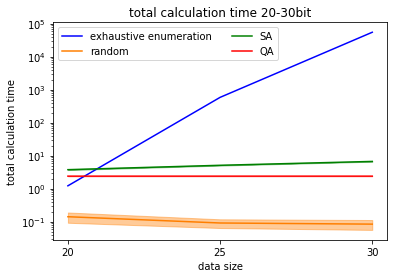

In [192]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_time_30['random'] + std_time_30['random'], mean_time_30['random'] - std_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_time_30['SA'] + std_time_30['SA'], mean_time_30['SA'] - std_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_time_30['QA'] + std_time_30['QA'], mean_time_30['QA'] - std_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('total calculation time 20-30bit')
plt.savefig('nn/_30bit_total_calculation_time_mean_std_log.png')
plt.show()

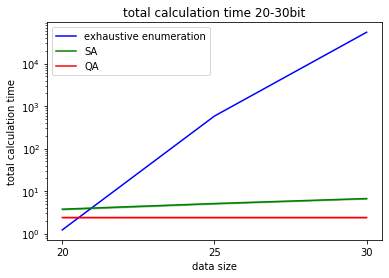

In [193]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
#ax.plot(bit_list_30, mean_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4, color='b')
#ax.fill_between(bit_list_30, mean_time_30['random'] + std_time_30['random'], mean_time_30['random'] - std_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_time_30['SA'] + std_time_30['SA'], mean_time_30['SA'] - std_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_time_30['QA'] + std_time_30['QA'], mean_time_30['QA'] - std_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left')
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('total calculation time 20-30bit')
plt.savefig('nn/norandom_30bit_total_calculation_time_mean_std_log.png')
plt.show()

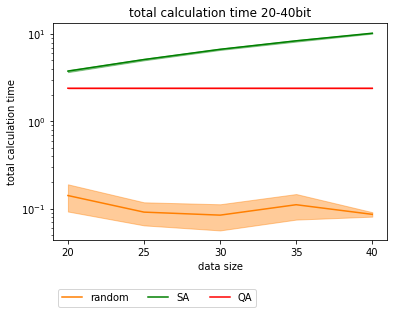

In [194]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
#ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('nn/_40bit_total_calculation_time_mean_std_log.png')
plt.show()

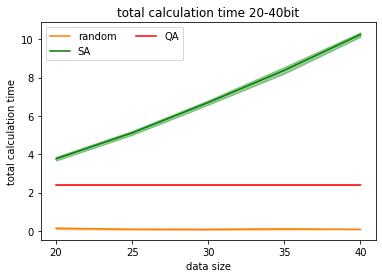

In [195]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('nn/_40bit_total_calculation_time_mean_std.png')
plt.show()

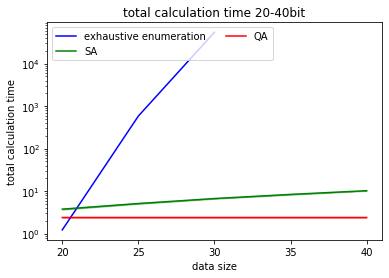

In [229]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
#ax.plot(bit_list_40, mean_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4)
###ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('nn/norandom_30bit_40bit_total_calculation_time_mean_std_log.png')
plt.show()

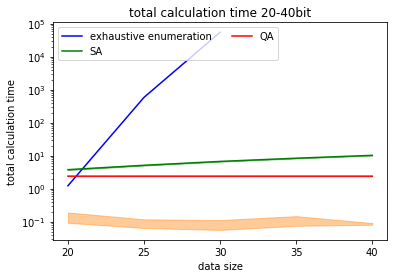

In [231]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
#ax.plot(bit_list_40, mean_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4)
ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('nn/norandom_30bit_40bit_total_calculation_time_mean_std_log.png')
plt.show()

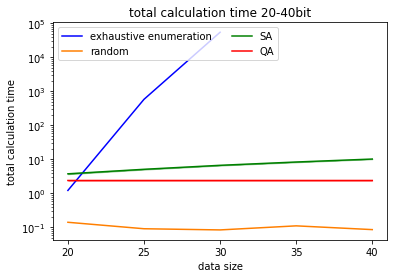

In [228]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_40, mean_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_time_30['enumeration'] + std_time_30['enumeration'], mean_time_30['enumeration'] - std_time_30['enumeration'], alpha=0.4)
#ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00#ax.fill_between(bit_list_40, mean_time_40['random'] + std_time_40['random'], mean_time_40['random'] - std_time_40['random'], alpha=0.4, color='#ff7f00'#)
ax.fill_between(bit_list_40, mean_time_40['SA'] + std_time_40['SA'], mean_time_40['SA'] - std_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_time_40['QA'] + std_time_40['QA'], mean_time_40['QA'] - std_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('total calculation time')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total calculation time 20-40bit')
plt.savefig('nn/_30bit_40bit_total_calculation_time_mean_log.png')
plt.show()

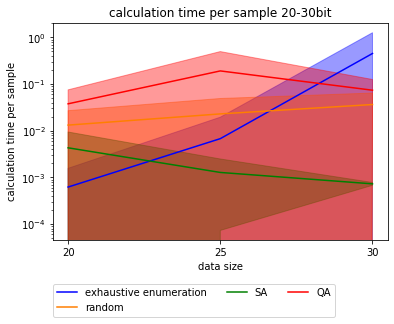

In [197]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('nn/enustd_30bit_per_time_mean_std_log.png')
plt.show()

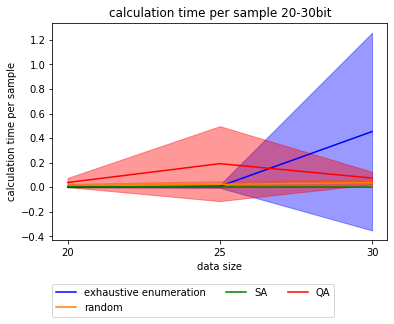

In [198]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('nn/enustd_30bit_per_time_mean_std.png')
plt.show()

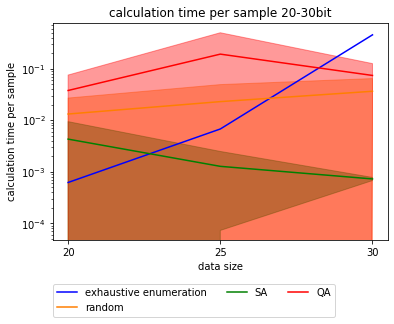

In [199]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('nn/_30bit_per_time_mean_std_log.png')
plt.show()

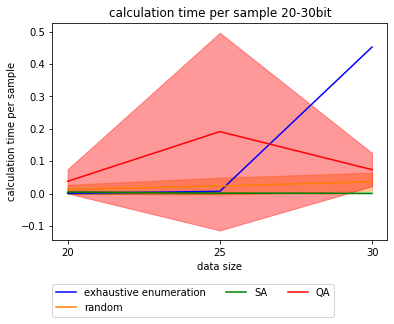

In [200]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_per_time_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_per_time_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_per_time_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_per_time_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_per_time_30['enumeration'] + std_per_time_30['enumeration'], mean_per_time_30['enumeration'] - std_per_time_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_per_time_30['random'] + std_per_time_30['random'], mean_per_time_30['random'] - std_per_time_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_per_time_30['SA'] + std_per_time_30['SA'], mean_per_time_30['SA'] - std_per_time_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_per_time_30['QA'] + std_per_time_30['QA'], mean_per_time_30['QA'] - std_per_time_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('calculation time per sample 20-30bit')
plt.savefig('nn/_30bit_per_time_mean_std.png')
plt.show()

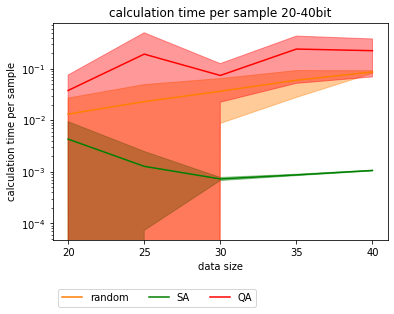

In [203]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_per_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_per_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_per_time_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_per_time_40['random'] + std_per_time_40['random'], mean_per_time_40['random'] - std_per_time_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_per_time_40['SA'] + std_per_time_40['SA'], mean_per_time_40['SA'] - std_per_time_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_per_time_40['QA'] + std_per_time_40['QA'], mean_per_time_40['QA'] - std_per_time_40['QA'], alpha=0.4, color='r')

ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
#ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('calculation time per sample 20-40bit')
plt.savefig('nn/_40bit_per_time_mean_std_log.png')
plt.show()

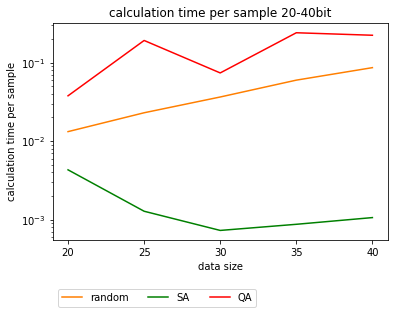

In [206]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_per_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_per_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_per_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_per_time_40['random'] + std_per_time_40['random'], mean_per_time_40['random'] - std_per_time_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_per_time_40['SA'] + std_per_time_40['SA'], mean_per_time_40['SA'] - std_per_time_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_per_time_40['QA'] + std_per_time_40['QA'], mean_per_time_40['QA'] - std_per_time_40['QA'], alpha=0.4, color='r')

ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
#ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('calculation time per sample 20-40bit')
plt.savefig('nn/_40bit_per_time_mean_log.png')
plt.show()

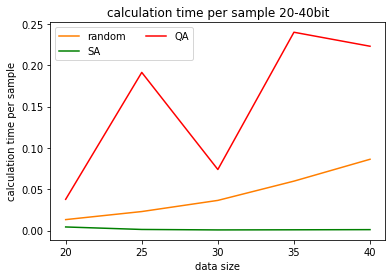

In [207]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_per_time_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_per_time_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_per_time_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_per_time_40['random'] + std_per_time_40['random'], mean_per_time_40['random'] - std_per_time_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_per_time_40['SA'] + std_per_time_40['SA'], mean_per_time_40['SA'] - std_per_time_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_per_time_40['QA'] + std_per_time_40['QA'], mean_per_time_40['QA'] - std_per_time_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('calculation time per sample')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('calculation time per sample 20-40bit')
plt.savefig('nn/_40bit_per_time_mean.png')
plt.show()

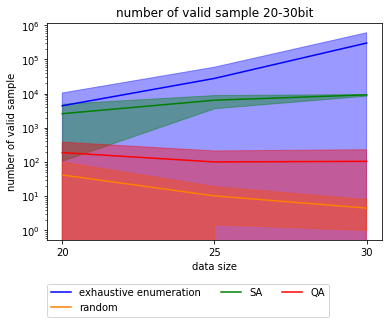

In [208]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_valid_y_num_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_valid_y_num_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_valid_y_num_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_valid_y_num_30['QA'], label='QA', color='r')

ax.fill_between(bit_list_30, mean_valid_y_num_30['enumeration'] + std_valid_y_num_30['enumeration'], mean_valid_y_num_30['enumeration'] - std_valid_y_num_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_valid_y_num_30['random'] + std_valid_y_num_30['random'], mean_valid_y_num_30['random'] - std_valid_y_num_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_valid_y_num_30['SA'] + std_valid_y_num_30['SA'], mean_valid_y_num_30['SA'] - std_valid_y_num_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_valid_y_num_30['QA'] + std_valid_y_num_30['QA'], mean_valid_y_num_30['QA'] - std_valid_y_num_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=3)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('number of valid sample 20-30bit')
plt.savefig('nn/enustd_30bit_valid_y_num_mean_std_log.png')
plt.show()

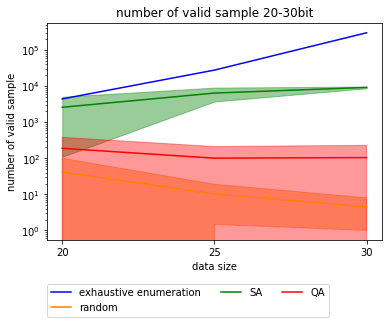

In [209]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_valid_y_num_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_valid_y_num_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_valid_y_num_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_valid_y_num_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_valid_y_num_30['enumeration'] + std_valid_y_num_30['enumeration'], mean_valid_y_num_30['enumeration'] - std_valid_y_num_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_valid_y_num_30['random'] + std_valid_y_num_30['random'], mean_valid_y_num_30['random'] - std_valid_y_num_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_valid_y_num_30['SA'] + std_valid_y_num_30['SA'], mean_valid_y_num_30['SA'] - std_valid_y_num_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_valid_y_num_30['QA'] + std_valid_y_num_30['QA'], mean_valid_y_num_30['QA'] - std_valid_y_num_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=3)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('number of valid sample 20-30bit')
plt.savefig('nn/_30bit_valid_y_num_mean_std_log.png')
plt.show()

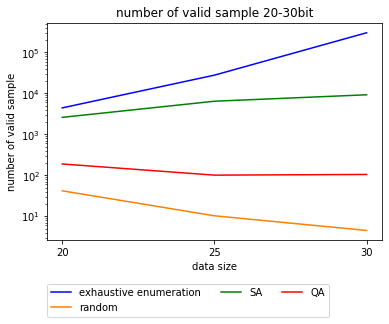

In [210]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_valid_y_num_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_valid_y_num_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_valid_y_num_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_valid_y_num_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_valid_y_num_30['enumeration'] + std_valid_y_num_30['enumeration'], mean_valid_y_num_30['enumeration'] - std_valid_y_num_30['enumeration'], alpha=0.4, color='b')
#ax.fill_between(bit_list_30, mean_valid_y_num_30['random'] + std_valid_y_num_30['random'], mean_valid_y_num_30['random'] - std_valid_y_num_30['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_30, mean_valid_y_num_30['SA'] + std_valid_y_num_30['SA'], mean_valid_y_num_30['SA'] - std_valid_y_num_30['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_30, mean_valid_y_num_30['QA'] + std_valid_y_num_30['QA'], mean_valid_y_num_30['QA'] - std_valid_y_num_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
#ax.legend(loc='upper left', ncol=3)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_30)
ax.set_yscale('log')
plt.title('number of valid sample 20-30bit')
plt.savefig('nn/_30bit_valid_y_num_mean_log.png')
plt.show()

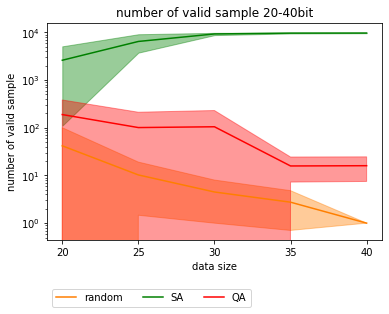

In [213]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_valid_y_num_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_valid_y_num_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_valid_y_num_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_valid_y_num_40['random'] + std_valid_y_num_40['random'], mean_valid_y_num_40['random'] - std_valid_y_num_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_valid_y_num_40['SA'] + std_valid_y_num_40['SA'], mean_valid_y_num_40['SA'] - std_valid_y_num_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_valid_y_num_40['QA'] + std_valid_y_num_40['QA'], mean_valid_y_num_40['QA'] - std_valid_y_num_40['QA'], alpha=0.4, color='r')

ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=3)
#ax.legend(loc='lower left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('number of valid sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('number of valid sample 20-40bit')
plt.savefig('nn/_40bit_valid_y_num_mean_std_log.png')
plt.show()

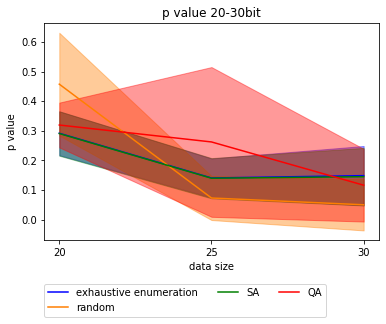

In [214]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_p_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_p_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_p_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_p_30['QA'], label='QA', color='r')

ax.fill_between(bit_list_30, mean_p_30['enumeration'] + std_p_30['enumeration'], mean_p_30['enumeration'] - std_p_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_p_30['random'] + std_p_30['random'], mean_p_30['random'] - std_p_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_p_30['SA'] + std_p_30['SA'], mean_p_30['SA'] - std_p_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_p_30['QA'] + std_p_30['QA'], mean_p_30['QA'] - std_p_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
#ax.legend(loc='lower left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('p value 20-30bit')
plt.savefig('nn/enustd_30bit_p_mean_std.png')
plt.show()

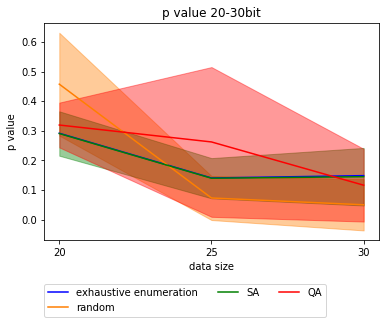

In [215]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_p_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_p_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_p_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_p_30['QA'], label='QA', color='r')

#ax.fill_between(bit_list_30, mean_p_30['enumeration'] + std_p_30['enumeration'], mean_p_30['enumeration'] - std_p_30['enumeration'], alpha=0.4, color='b')
ax.fill_between(bit_list_30, mean_p_30['random'] + std_p_30['random'], mean_p_30['random'] - std_p_30['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_30, mean_p_30['SA'] + std_p_30['SA'], mean_p_30['SA'] - std_p_30['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_30, mean_p_30['QA'] + std_p_30['QA'], mean_p_30['QA'] - std_p_30['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, fontsize=10, ncol = 3)
#ax.legend(loc='lower left', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('p value 20-30bit')
plt.savefig('nn/_30bit_p_mean_std.png')
plt.show()

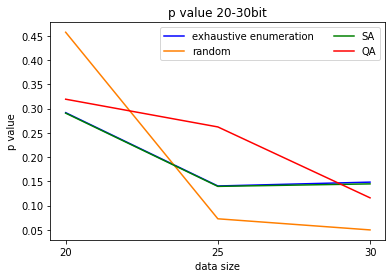

In [216]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_p_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_30, mean_p_30['random'], label='random', color='#ff7f00')
ax.plot(bit_list_30, mean_p_30['SA'], label='SA', color='g')
ax.plot(bit_list_30, mean_p_30['QA'], label='QA', color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper right', ncol=2)
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_30)
#ax.set_yscale('log')
plt.title('p value 20-30bit')
plt.savefig('nn/_30bit_p_mean.png')
plt.show()

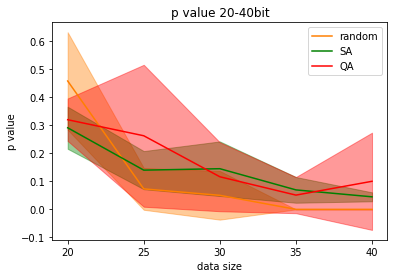

In [217]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_p_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_p_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_p_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_p_40['random'] + std_p_40['random'], mean_p_40['random'] - std_p_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_p_40['SA'] + std_p_40['SA'], mean_p_40['SA'] - std_p_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_p_40['QA'] + std_p_40['QA'], mean_p_40['QA'] - std_p_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper right')
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('p value 20-40bit')
plt.savefig('nn/_40bit_p_mean_std.png')
plt.show()

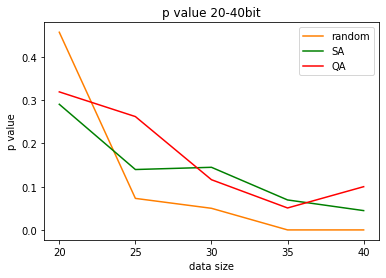

In [218]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_p_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_p_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_p_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_p_40['random'] + std_p_40['random'], mean_p_40['random'] - std_p_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_p_40['SA'] + std_p_40['SA'], mean_p_40['SA'] - std_p_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_p_40['QA'] + std_p_40['QA'], mean_p_40['QA'] - std_p_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper right')
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('p value 20-40bit')
plt.savefig('nn/_40bit_p_mean.png')
plt.show()

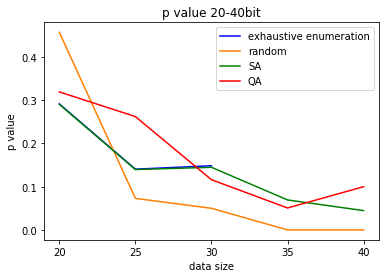

In [220]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_p_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_40, mean_p_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_p_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_p_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_p_40['random'] + std_p_40['random'], mean_p_40['random'] - std_p_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_p_40['SA'] + std_p_40['SA'], mean_p_40['SA'] - std_p_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_p_40['QA'] + std_p_40['QA'], mean_p_40['QA'] - std_p_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper right')
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('p value 20-40bit')
plt.savefig('nn/_30bit_40bit_p_mean.png')
plt.show()

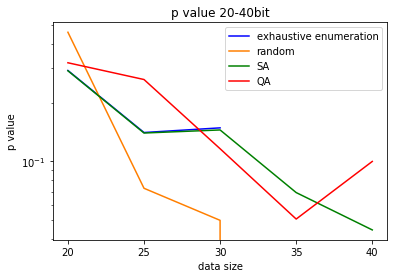

In [221]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_30, mean_p_30['enumeration'], label='exhaustive enumeration', color='b')
ax.plot(bit_list_40, mean_p_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_p_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_p_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_p_40['random'] + std_p_40['random'], mean_p_40['random'] - std_p_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_p_40['SA'] + std_p_40['SA'], mean_p_40['SA'] - std_p_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_p_40['QA'] + std_p_40['QA'], mean_p_40['QA'] - std_p_40['QA'], alpha=0.4, color='r')

#ax.legend(bbox_to_anchor=(0, -0.2), loc='upper left', ncol=2)
ax.legend(loc='upper right')
ax.set_xlabel('data size')
ax.set_ylabel('p value')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('p value 20-40bit')
plt.savefig('nn/_30bit_40bit_p_mean_log.png')
plt.show()

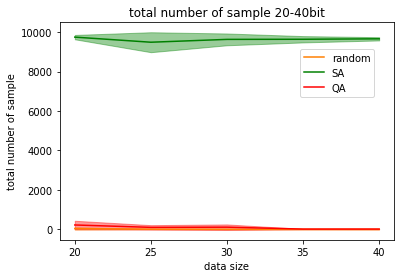

In [222]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_total_y_num_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_total_y_num_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_total_y_num_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_total_y_num_40['random'] + std_total_y_num_40['random'], mean_total_y_num_40['random'] - std_total_y_num_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_total_y_num_40['SA'] + std_total_y_num_40['SA'], mean_total_y_num_40['SA'] - std_total_y_num_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_total_y_num_40['QA'] + std_total_y_num_40['QA'], mean_total_y_num_40['QA'] - std_total_y_num_40['QA'], alpha=0.4, color='r')

plt.legend(bbox_to_anchor=(1, 0.97), loc='upper right', borderaxespad=2, fontsize=10)
#plt.legend(bbox_to_anchor=(0, 0.2), loc='upper left', borderaxespad=0.5, fontsize=10, ncol = 2)
ax.set_xlabel('data size')
ax.set_ylabel('total number of sample')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('total number of sample 20-40bit')
plt.savefig('nn\_40bit_total_y_num_mean_std.png')
plt.show()

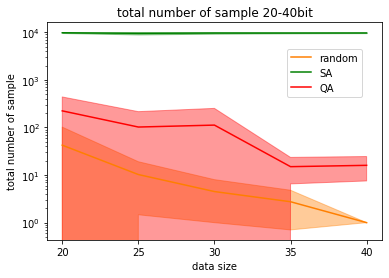

In [223]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_total_y_num_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_total_y_num_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_total_y_num_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_total_y_num_40['random'] + std_total_y_num_40['random'], mean_total_y_num_40['random'] - std_total_y_num_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_total_y_num_40['SA'] + std_total_y_num_40['SA'], mean_total_y_num_40['SA'] - std_total_y_num_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_total_y_num_40['QA'] + std_total_y_num_40['QA'], mean_total_y_num_40['QA'] - std_total_y_num_40['QA'], alpha=0.4, color='r')

plt.legend(bbox_to_anchor=(1, 0.97), loc='upper right', borderaxespad=2, fontsize=10)
#plt.legend(bbox_to_anchor=(0, 0.2), loc='upper left', borderaxespad=0.5, fontsize=10, ncol = 2)
ax.set_xlabel('data size')
ax.set_ylabel('total number of sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total number of sample 20-40bit')
plt.savefig('nn\_40bit_total_y_num_mean_std_log.png')
plt.show()

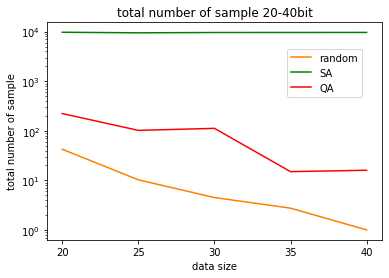

In [224]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_total_y_num_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_total_y_num_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_total_y_num_40['QA'], label='QA', color='r')

#ax.fill_between(bit_list_40, mean_total_y_num_40['random'] + std_total_y_num_40['random'], mean_total_y_num_40['random'] - std_total_y_num_40['random'], alpha=0.4, color='#ff7f00')
#ax.fill_between(bit_list_40, mean_total_y_num_40['SA'] + std_total_y_num_40['SA'], mean_total_y_num_40['SA'] - std_total_y_num_40['SA'], alpha=0.4, color='g')
#ax.fill_between(bit_list_40, mean_total_y_num_40['QA'] + std_total_y_num_40['QA'], mean_total_y_num_40['QA'] - std_total_y_num_40['QA'], alpha=0.4, color='r')

plt.legend(bbox_to_anchor=(1, 0.97), loc='upper right', borderaxespad=2, fontsize=10)
#plt.legend(bbox_to_anchor=(0, 0.2), loc='upper left', borderaxespad=0.5, fontsize=10, ncol = 2)
ax.set_xlabel('data size')
ax.set_ylabel('total number of sample')

ax.set_xticks(bit_list_40)
ax.set_yscale('log')
plt.title('total number of sample 20-40bit')
plt.savefig('nn\_40bit_total_y_num_mean_log.png')
plt.show()

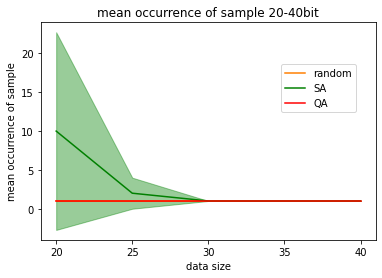

In [225]:
fig, ax = plt.subplots(1)

ax.plot(bit_list_40, mean_occurrence_40['random'], label='random', color='#ff7f00')
ax.plot(bit_list_40, mean_occurrence_40['SA'], label='SA', color='g')
ax.plot(bit_list_40, mean_occurrence_40['QA'], label='QA', color='r')

ax.fill_between(bit_list_40, mean_occurrence_40['random'] + std_occurrence_40['random'], mean_occurrence_40['random'] - std_occurrence_40['random'], alpha=0.4, color='#ff7f00')
ax.fill_between(bit_list_40, mean_occurrence_40['SA'] + std_occurrence_40['SA'], mean_occurrence_40['SA'] - std_occurrence_40['SA'], alpha=0.4, color='g')
ax.fill_between(bit_list_40, mean_occurrence_40['QA'] + std_occurrence_40['QA'], mean_occurrence_40['QA'] - std_occurrence_40['QA'], alpha=0.4, color='r')

#ax.legend(loc='upper left', ncol=2)
plt.legend(bbox_to_anchor=(1, 0.9), loc='upper right', borderaxespad=2, fontsize=10)
ax.set_xlabel('data size')
ax.set_ylabel('mean occurrence of sample')

ax.set_xticks(bit_list_40)
#ax.set_yscale('log')
plt.title('mean occurrence of sample 20-40bit')
plt.savefig('nn\_40bit_mean_occurrence_mean_std.png')
plt.show()